In [1]:
import os
import sys
import time
import numpy as np
from glob import glob

import logging
import warnings

warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

logging.getLogger("tensorflow").setLevel(logging.ERROR) 

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import vae_utils as vu
import model_utils as mu

In [5]:
#from skimage.transform import resize

In [6]:
print('tf.version = {}'.format(tf.__version__))
print('tf on GPU = {}'.format(tf.test.is_gpu_available()))

tf.version = 2.12.1
tf on GPU = True


In [7]:
def resblock(X, kernel_size, filter_num, activation):
    Fx = layers.Conv2D(filter_num, kernel_size, padding='same')(X)
    Fx = layers.BatchNormalization()(Fx)
    Fx = layers.Activation(activation)(Fx)
    Fx = layers.Conv2D(filter_num, kernel_size, padding='same')(Fx)
    out = layers.Add()([X, Fx])
    out = layers.BatchNormalization(axis=-1)(out)
    out = layers.Activation(activation)(out)
    return out

In [8]:
class VectorQuantizer(keras.layers.Layer):  
    def __init__(self, k, **kwargs):
        super(VectorQuantizer, self).__init__(**kwargs)
        self.k = k
    
    def build(self, input_shape):
        self.d = int(input_shape[-1])
        rand_init = keras.initializers.VarianceScaling(distribution="uniform")
        self.codebook = self.add_weight(shape=(self.k, self.d), initializer=rand_init, trainable=True)
        
    def call(self, inputs):
        # Map z_e of shape (b, w,, h, d) to indices in the codebook
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        z_e = tf.expand_dims(inputs, -2)
        dist = tf.norm(z_e - lookup_, axis=-1)
        k_index = tf.argmin(dist, axis=-1)
        return k_index
    
    def sample(self, k_index):
        # Map indices array of shape (b, w, h) to actual codebook z_q
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        k_index_one_hot = tf.one_hot(k_index, self.k)
        z_q = lookup_ * k_index_one_hot[..., None]
        z_q = tf.reduce_sum(z_q, axis=-2)
        return z_q

In [9]:
filter_nums = [64, 128]
latent_dim = 16
num_embeddings = 128
activation = 'relu'

model_name_save = '/glade/work/ksha/GAN/models/VQ_VAE_GAN_{}_{}_L{}_N{}_{}_base.hdf5'.format(filter_nums[0], 
                                                                                        filter_nums[1], 
                                                                                        latent_dim, 
                                                                                        num_embeddings, 
                                                                                        activation)

model_de_save = '/glade/work/ksha/GAN/models/VQ_VAE_DE_{}_{}_L{}_N{}_{}_base.hdf5'.format(filter_nums[0], 
                                                                                     filter_nums[1], 
                                                                                     latent_dim, 
                                                                                     num_embeddings, 
                                                                                     activation)

model_ge_save = '/glade/work/ksha/GAN/models/VQ_VAE_GE_{}_{}_L{}_N{}_{}_base.hdf5'.format(filter_nums[0], 
                                                                                     filter_nums[1], 
                                                                                     latent_dim, 
                                                                                     num_embeddings, 
                                                                                     activation)

input_size = (128, 128, 1) #(28, 28, 1) #
latent_size = (32, 32, latent_dim) #(7, 7, latent_dim) #
# 64 144

# ================================= encoder ================================= #

encoder_in = keras.Input(shape=input_size)
X = encoder_in

X = layers.Conv2D(filter_nums[0], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = resblock(X, 3, filter_nums[0], activation)
X = resblock(X, 3, filter_nums[0], activation)

X = layers.Conv2D(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = resblock(X, 3, filter_nums[1], activation)
X = resblock(X, 3, filter_nums[1], activation)

z_e = layers.Conv2D(latent_dim, 1, padding="same")(X)

vector_quantizer = VectorQuantizer(num_embeddings, name="vector_quantizer")

codebook_indices = vector_quantizer(z_e)

model_encoder = keras.Model(inputs=encoder_in, outputs=codebook_indices, name='encoder')
# =========================================================================== #

# ================================= decoder ================================= #

decoder_in = keras.Input(shape=latent_size)

X = decoder_in

X = layers.Conv2D(filter_nums[1], 1, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2DTranspose(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = resblock(X, 3, filter_nums[1], activation)
X = resblock(X, 3, filter_nums[1], activation)

X = layers.Conv2DTranspose(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = resblock(X, 3, filter_nums[0], activation)
X = resblock(X, 3, filter_nums[0], activation)

decoder_out = layers.Conv2D(1, 1, padding="same")(X)

model_decoder = keras.Model(decoder_in, decoder_out, name='decoder')

# ================================= VQ-VAE ================================= #

sampling_layer = keras.layers.Lambda(lambda x: vector_quantizer.sample(x), name="sample_from_codebook")
z_q = sampling_layer(codebook_indices)

codes = tf.stack([z_e, z_q], axis=-1)

codes = keras.layers.Lambda(lambda x: x, name='code_mapping')(codes)

straight_through = keras.layers.Lambda(lambda x : x[1] + tf.stop_gradient(x[0] - x[1]), name='stop_gradient')
straight_through_zq = straight_through([z_q, z_e])

reconstructed = model_decoder(straight_through_zq)

vq_vae = keras.Model(inputs=encoder_in, outputs=[reconstructed, codes], name='vq-vae')

In [10]:
IN = keras.Input(shape=input_size)

X = IN

X = layers.Conv2D(filter_nums[0], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[0], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[1], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[1], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[1], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

V = X
V = keras.layers.GlobalMaxPooling2D()(V)
OUT = keras.layers.Dense(1, activation='sigmoid')(V)

model_de = keras.Model(IN, OUT)

In [11]:
IN_ge = keras.Input(shape=input_size)

G_OUT, vq_codes = vq_vae(IN_ge)
D_OUT = model_de(G_OUT)

GAN = keras.models.Model(IN_ge, [G_OUT, vq_codes, D_OUT])

In [12]:
def mse_loss(ground_truth, predictions):
    mse_loss = tf.reduce_mean((ground_truth - predictions)**2, name="mse_loss")
    return mse_loss

def latent_loss(dummy_ground_truth, outputs):
    del dummy_ground_truth
    z_e, z_q = tf.split(outputs, 2, axis=-1)
    vq_loss = tf.reduce_mean((tf.stop_gradient(z_e) - z_q)**2)
    commit_loss = tf.reduce_mean((z_e - tf.stop_gradient(z_q))**2)
    latent_loss = tf.identity(vq_loss + 0.25 * commit_loss, name="latent_loss")
    return latent_loss

In [13]:
vq_vae.compile(loss=[mse_loss, latent_loss], optimizer= keras.optimizers.Adam(1e-5))
model_de.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.Adam(1e-5))
GAN.compile(loss=[mse_loss, latent_loss, keras.losses.BinaryCrossentropy(from_logits=False)], 
            loss_weights=[1.0, 1.0, 0.1], optimizer=keras.optimizers.Adam(1e-5))

In [14]:
###GAN.load_weights(model_name_save)
model_de.load_weights(model_de_save)
vq_vae.load_weights(model_ge_save)

In [15]:
def precip_norm(x):
    return np.log(x+1)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/'

L_valid = 5000

filenames = np.array(sorted(glob(BATCH_dir+'*2020*.npy')))
L = len(filenames)

filename_valid = filenames[::8][:L_valid]
filename_train = list(set(filenames) - set(filename_valid))
L_train = len(filename_train)

Y_valid = np.empty((L_valid, 128, 128, 1))
for i, name in enumerate(filename_valid):
    Y_valid[i, ..., 0] = precip_norm(np.load(name))

In [16]:
# BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/'
# filename_train = sorted(glob(BATCH_dir+'*.npy'))
# L_train = len(filename_train)

# epochs = 99999
# N_batch = 64
# batch_size = 64

# min_del = 0.0
# max_tol = 3 # early stopping with 2-epoch patience
# tol = 0

# Y_batch = np.empty((batch_size, 128, 128, 1))
# Y_batch[...] = np.nan

# y_bad = np.zeros(batch_size)
# y_good = np.ones(batch_size)
# dummy_good = y_good
# dummy_mix = np.concatenate((y_bad, y_good), axis=0)

# for i in range(epochs):
#     print('epoch = {}'.format(i))
#     if i == 0:
#         Y_pred, _ = vq_vae.predict(Y_valid)
#         record = mean_absolute_error(Y_valid, Y_pred)
#         print('Initial validation loss: {}'.format(record))
    
#     start_time = time.time()
#     for j in range(N_batch):
        
#         inds_rnd = du.shuffle_ind(L_train)
#         inds_ = inds_rnd[:batch_size]

#         for k, ind in enumerate(inds_):
#             # import batch data
#             name = filename_train[ind]
#             temp_data = np.load(name)
#             Y_batch[k, ..., 0] = temp_data[0, ..., 0]

#         # get G_output
#         model_de.trainable = True
#         g_out, _ = vq_vae.predict(Y_batch, verbose=0) # <-- np.array

#         d_in_Y = np.concatenate((g_out, Y_batch), axis=0) # batch size doubled
#         d_target = dummy_mix
        
#         batch_ind = du.shuffle_ind(2*batch_size)
#         d_loss = model_de.train_on_batch(d_in_Y[batch_ind, ...], d_target[batch_ind, ...])

#         model_de.trainable = False
#         gan_in = Y_batch
#         gan_target = [Y_batch, Y_batch, dummy_good]
#         gan_loss = GAN.train_on_batch(gan_in, gan_target)
        
#     # on epoch-end
#     Y_pred, _ = vq_vae.predict(Y_valid)
#     record_temp = mean_absolute_error(Y_valid, Y_pred)
    
#     if record - record_temp > min_del:
#         print('Validation loss improved from {} to {}'.format(record, record_temp))
#         record = record_temp
#         GAN.save_weights(model_name_save, overwrite=True)
#         model_de.save_weights(model_de_save, overwrite=True)
#         vq_vae.save_weights(model_ge_save, overwrite=True)
        
#     else:
#         print('Validation loss {} NOT improved'.format(record_temp))

#     print("--- %s seconds ---" % (time.time() - start_time))
#     # mannual callbacks

In [ ]:
# https://www.kaggle.com/code/ameroyer/keras-vq-vae-for-image-generation

In [17]:
Y_pred, _ = vq_vae.predict(Y_valid)

157/157 [==============================] - 7s 37ms/step


In [19]:
# codebook_indices = model_encoder.predict(Y_valid)
# z_q = sampling_layer(codebook_indices)
# reconstructed = model_decoder.predict(z_q)

In [20]:
mean_absolute_error(Y_valid, Y_pred)

0.01743470756098142

In [60]:
# 0.014254429761548011

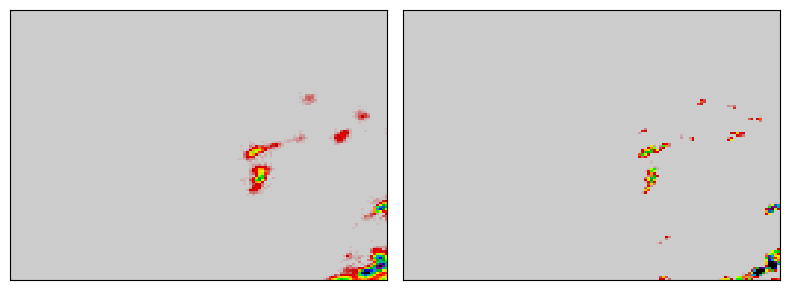

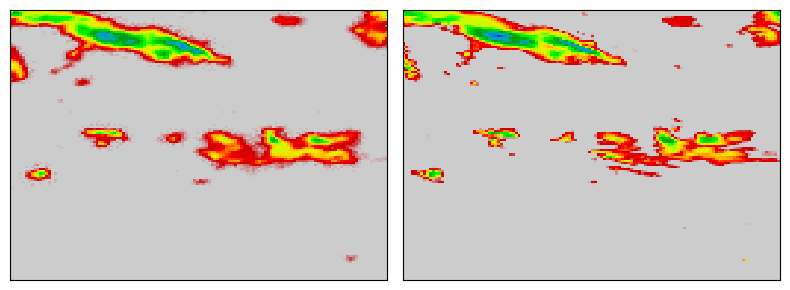

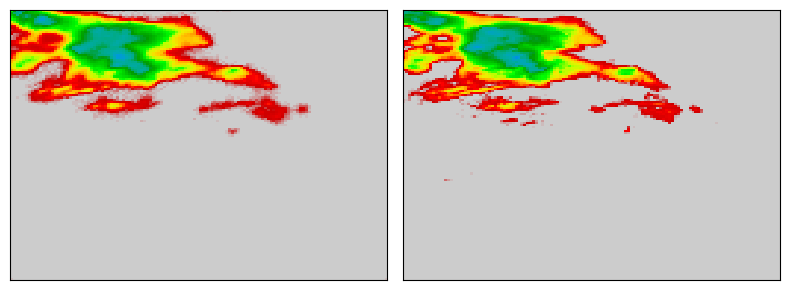

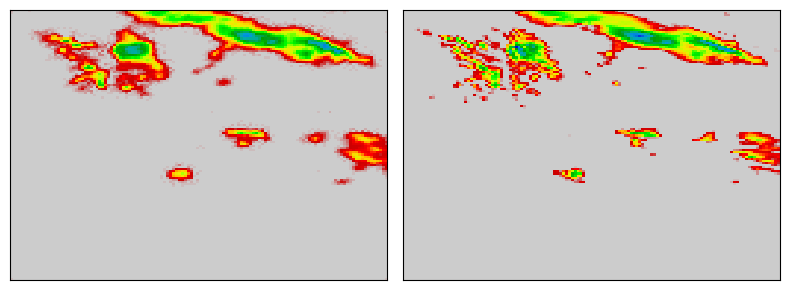

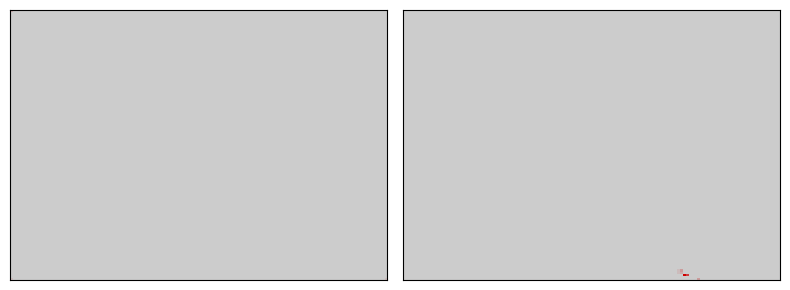

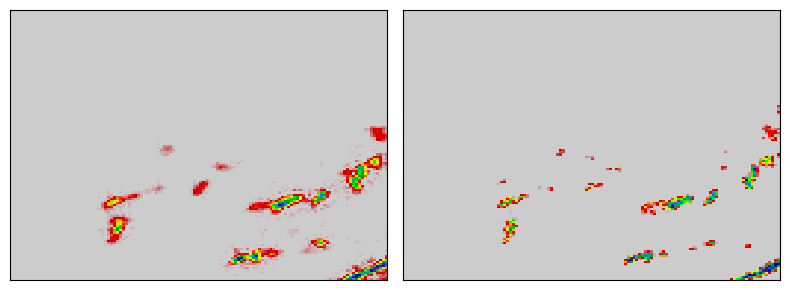

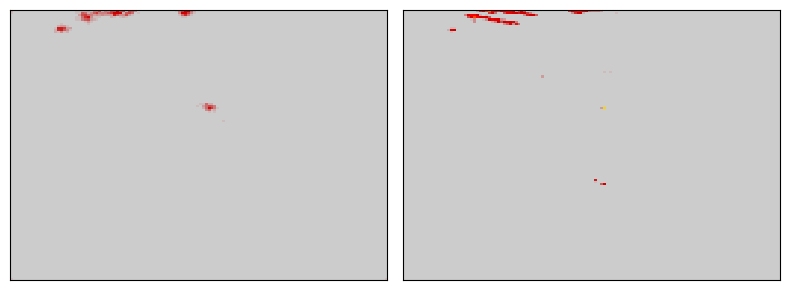

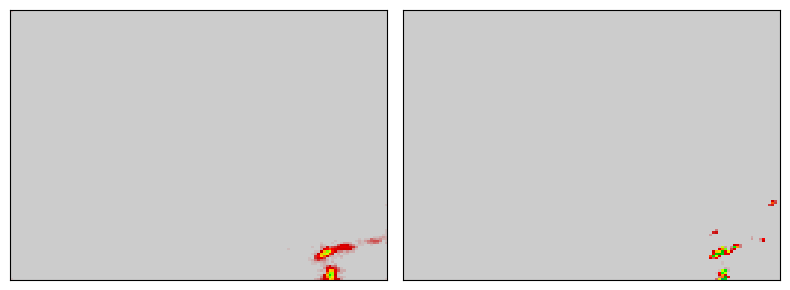

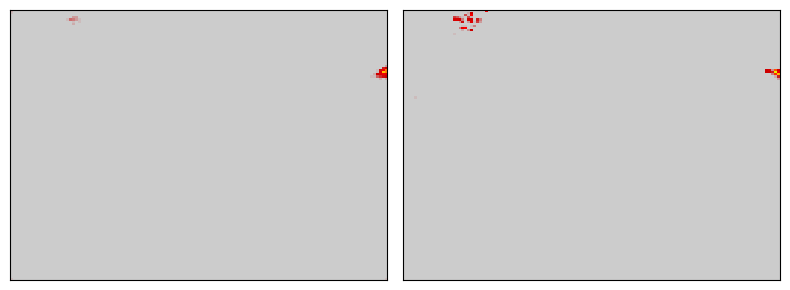

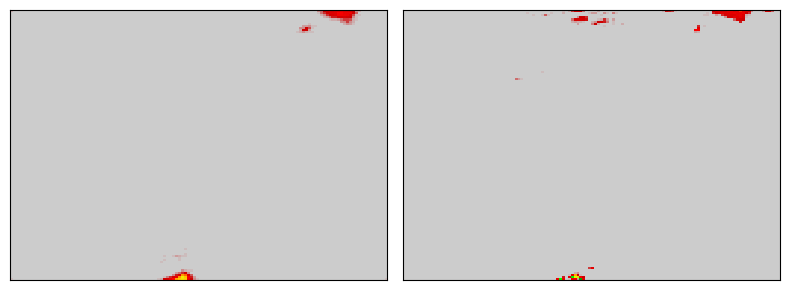

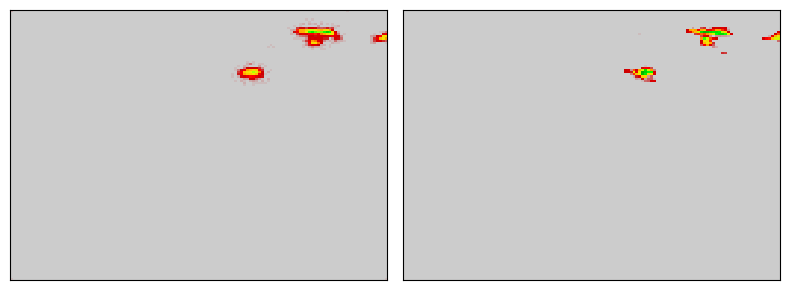

In [21]:
for i in range(30, 41, 1):

    fig, AX = plt.subplots(1, 2, figsize=(8, 3))
    
    for ax in AX:
        ax.tick_params(axis="both", which="both", bottom=False, 
                       top=False, labelbottom=False, left=False,
                       right=False, labelleft=False)
    plt.tight_layout()
    
    AX[0].pcolormesh(Y_pred[i, ..., 0], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r)
    AX[1].pcolormesh(Y_valid[i, ..., 0], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r)